In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px

In [3]:
sns.set(                        # set - настройки графика
    font_scale =2,              # размер шрифта
    style      ='whitegrid',    # стиль графика
    rc         ={'figure.figsize':(20,7)})  # размер графика

In [3]:
# Разберемся с распределением количества показов и кликов.
#Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

# Нарисуйте график распределения показов на объявление за весь период.

# А теперь давайте посчитаем скользящее среднее показов с окном 2.
#Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

# Скользящее среднее часто используется для поиска аномалий в данных. 
#Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов.
#В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? 
#Дни, в которых скользящее среднее равно NaN, не учитываем. 

# *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день,
# в который была замечена самая большая по модулю аномалия. 

# *Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента 
#и первым запуском рекламного объявления этим клиентом.

# *Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней.
#Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))

# *Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30.
# Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).
#Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]

# *А теперь давайте выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

In [46]:
ads_clients = pd.read_csv('ads_clients_data.csv')
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [47]:
ads = pd.read_csv('ads_data.csv')
ads.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


## 1.Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

### Вариант 1

In [5]:
number_per_event = ads.groupby(['ad_id','event'],as_index=False)  \
                      .agg({'time': 'count'})  \
                      .rename(columns={'time': 'event_number'})

In [6]:
pivot_events = number_per_event.pivot(index='ad_id', # используем сводную таблицу
                       columns='event', 
                       values='event_number') \
                    .fillna(0)

In [7]:
pivot_events.mean().round()

event
click    113.0
view     923.0
dtype: float64

### Вариант 2

In [8]:
number_per_event = ads.groupby(['ad_id','event'],as_index=False)  \
                      .agg({'time': 'count'})  \
                      .rename(columns={'time': 'event_number'})

In [9]:
div_events = number_per_event.groupby('event') \
                             .agg({'event_number': 'sum'}) \
                             .div(number_per_event.ad_id.nunique()) \
                             .round()

## 2.Нарисуйте график распределения показов на объявление за весь период

In [10]:
views_per_ad = number_per_event.query('event == "view"')

In [11]:
views_per_ad['log_views'] = np.log(views_per_ad.event_number)   # перевести просмотры в логорифмы

<ipython-input-11-0248913b5254>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  views_per_ad['log_views'] = np.log(views_per_ad.event_number)   # перевести просмотры в логорифмы


C:\Users\ALEXEY\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_views', ylabel='Density'>

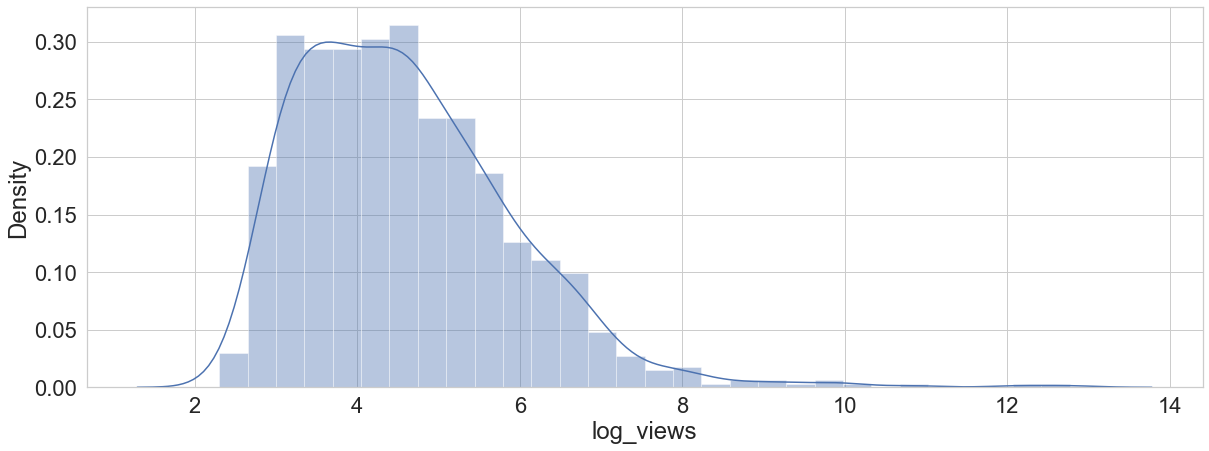

In [12]:
sns.distplot(views_per_ad.log_views)

## 3. А теперь давайте посчитаем скользящее среднее показов с окном 2.
#Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

In [13]:
ads_view_per_date = ads.query('event == "view"') \
                       .pivot_table(index='ad_id', 
                                    columns='date', 
                                    values='time',
                                    aggfunc='count')

In [14]:
mean_views = ads_view_per_date.mean()

In [16]:
roling_means_views = mean_views.rolling(2).mean()

In [17]:
roling_means_views['2019-04-06'].round()

598.0

## 4. Скользящее среднее часто используется для поиска аномалий в данных. 
Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов.
В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? 
Дни, в которых скользящее среднее равно NaN, не учитываем. 

<AxesSubplot:xlabel='date'>

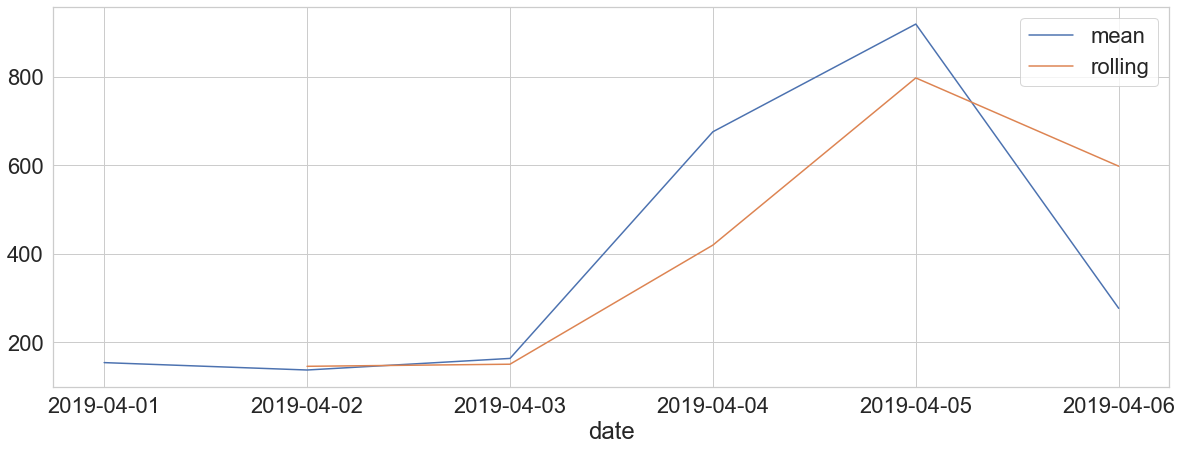

In [18]:
sns.lineplot(data =mean_views,label = 'mean')
sns.lineplot(data = roling_means_views, label = 'rolling')


In [19]:
anomaly_day = (mean_views - roling_means_views).abs().idxmax() 
# макс дата
anomaly_day

'2019-04-06'

## 5. Напишите функцию
которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день, в который была замечена самая большая по модулю аномалия. 

In [20]:
ads_view_per_date['2019-04-06'].max()

48991.0

In [21]:
dif_val = (mean_views - roling_means_views)[anomaly_day]

In [22]:
#find max view ad
if dif_val <= 0:
    
    anomaly_ad = ads_view_per_date[anomaly_day].idxmax()
#find min view ad    
else:
    anomaly_ad = ads_view_per_date[anomaly_day].idxmin() 
    

In [23]:
ads_view_per_date.loc[112583]

date
2019-04-01         NaN
2019-04-02         NaN
2019-04-03         NaN
2019-04-04         NaN
2019-04-05    302811.0
2019-04-06     48991.0
Name: 112583, dtype: float64

In [32]:
def find_anomaly_id(add_view_pre_day_per_ad):
    #find anomaly day
    #average for each date
    mean_views = add_view_pre_day_per_ad.mean()
    min_difference = (mean_views - roling_means_views)
    #find day whis anomaly
    anomaly_day = min_difference.abs().idxmax() 
    #find sign
    difference_value =min_difference[anomaly_day]
    #find maximum
    if difference_value <=0:
        anomaly_ad = add_view_pre_day_per_ad[anomaly_day].idxmax()
    #find minimum view ad
    else:
        anomaly_ad = add_view_pre_day_per_ad[anomaly_day].idxmin()
    return anomaly_ad

## 6. Теперь подгрузим данные по рекламным клиентам
и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

In [49]:
ads= ads.merge(ads_clients.drop(columns=['date', 'community_id']))
ads.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [50]:
ads[['date','create_date']] = ads[['date','create_date']].apply(pd.to_datetime)

In [65]:
# средний промежуток от создания кобинета до первой рекламы
create_to_start_mean = ads.groupby('client_union_id') \
.apply(lambda group: (group.date - group.create_date).min()).mean()

## 7. Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней.
Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))


In [61]:
trashold = pd.to_timedelta(365, unit='d')

In [68]:
#промежуток от создания кобинета до первой рекламы
create_to_start = ads.groupby('client_union_id') \
.apply(lambda group: (group.date - group.create_date).min())

In [72]:
create_to_start = create_to_start.loc[create_to_start < trashold]

In [81]:
convertions = round(create_to_start.shape[0] / ads_clients.client_union_id.nunique() * 100 ,2)

## 8. Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30.
Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).
Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]

In [85]:
bins = pd.to_timedelta([0, 30, 90, 180, 365], unit='d')

In [90]:
labels=['0-30', '30-90', '90-180', '180-365']

In [94]:
start_per_day = pd.cut(create_to_start, bins=bins, labels=labels)

In [97]:
total_start = start_per_day.value_counts()

## 9.А теперь давайте выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

In [99]:
px.bar(total_start)